In [27]:
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"  # ポップアウトウィンドウを表示しないようにする
from ple import PLE
from ple.games.flappybird import FlappyBird

In [28]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=16)
    
    anim.save('movie_flappy_bird_DQN.mp4')
    display(display_animation(anim, default_mode='once'))

In [29]:
def make_graph(reward_per_epoch, lifetime_per_epoch):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
    axL.set_title('lifetime')
    axL.grid(True)
    axL.plot(lifetime_per_epoch, color='magenta')
    axR.set_title('reward')
    axR.grid(True)
    axR.plot(reward_per_epoch , color='magenta')
    fig.show()

In [30]:
from collections import namedtuple

Transition = namedtuple('Transicion', ('state', 'action', 'next_state', 'reward'))

In [31]:
GAMMA = 0.99 # 時間割引率
MAX_STEPS = 1200 # 1試行のstep数(フレーム数)
NUM_EPISODES = 800 # 最大試行回数
PRINT_EVERY_EPISODE = 50
SHOW_GIF_EVERY_EPISODE = 100

In [32]:
class ReplayMemory:
    
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY #メモリの最大値
        self.memory = [] # 経験を保存するリスト
        self.index = 0 # 保存するindexを表す変数
    
    def push(self, state, action, state_next, reward):
        '''trasicion = (state, action, state_next, reward)をメモリ保存する'''
        
        if len(self.memory) < self.capacity:
            self.memory.append(None) # メモリが満タンじゃないときは足す
            
        # namedtupleのTransitionを用意し、値とフィールド名をペアにする
        self.memory[self.index] = Transition(state, action, state_next, reward)
            
        self.index = (self.index + 1) % self.capacity # 保存するindexを1つずらす
        
    def sample(self, batch_size):
        '''batch_sizeだけ、ランダムに取り出す'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''関数lenに対して、現在のmemoryの長さを返す'''
        return len(self.memory)

In [33]:
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [34]:
BATCH_SIZE = 32
CAPACITY = 10000

In [35]:
class Net(nn.Module):
    
    def __init__(self, num_states, num_actions):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_states, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, num_actions)
    
    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output

In [36]:
class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions # 行動の数を取得
        
        # 経験を保存するメモリオブジェクトを生成
        self.memory = ReplayMemory(CAPACITY)
        
        # NNを構築
        self.model = Net(num_states, num_actions)
        
        print(self.model) # ネットワークの形を出力
        
        # target_net
        self.target_net = copy.deepcopy(self.model)
        self.target_net.load_state_dict(self.model.state_dict())
        
        # 最適化手法の設定
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        
    def replay(self):
        '''Experience Replayでネットワークの結合パラメータを出力'''
        
        # 1.1 メモリサイズがミニバッチより小さい間は何もしない
        if len(self.memory) < BATCH_SIZE:
            return
        
        
        # 2.1 メモリからミニバッチ分のデータを取り出す
        transitions = self.memory.sample(BATCH_SIZE)
        
        # 2.2 各変数をミニバッチに対応する形に変形
        # trainsicionsは1stepごとの(state, action. state_next, reward)が、BATCH_SIZE分格納されている
        # つまり、(state, action, state_next, reward)xBATCH_SIZE
        # これをミニバッチにしたい
        # (state x BATCH_SIZE, action x BATCH_SIZE, state_next x BATCH_SIZE, reward x BATCH_SIZE)にする
        batch = Transition(*zip(*transitions))
        
        # 2.3  各変数の要素をミニバッチに対応する形に変形する
        # 例えばstateの場合、[torch.FloatTensor of size 1x4]がBATCH_SIZE分並んでいるが、
        # それを torch.FloatTensor of BATCH_SIZE x 4に変換する
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        
        # 3. 教師信号となるQ(s_t, a_t)値を求める
        self.model.eval()
        
        # 3.2 ネットワークが出力したQ(s_t, a_t)を求める
        # self.model(state_batch)は、右左の両方のQ値を出力しており
        # [torch.FloatTensor of size BATCH_SIZE x 2]になっている
        # ここから実行したアクションa_tに対応するQ値を求めるため、action_batchで行った行動a_tが
        # 右か左かのindexを求め、それに対応するQ値をgatherで引っ張り出す
        state_action_values = self.model(state_batch).gather(1, action_batch)
        
        # 3.3 max{Q(s_t+1, a)}値を求める。ただし、次の状態があるかに注意。
        
        # flappybirdがdoneになっておらず、next_stateがあるかをチェックするインデックスマスクを作成
        non_final_mask = torch.ByteTensor(
            tuple(map(lambda s: s is not None, batch.next_state)))
        
        # まずは全部0にしておく
        next_state_values = torch.zeros(BATCH_SIZE)
        
        # 次の状態があるindexの最大Q値を求める
        # 出力にアクセスし、max(1)で列方向の最大値の[値、index]を求める
        # そしてそのQ値を取り出します
        self.target_net.eval()
        next_state_values[non_final_mask] = self.target_net(
            non_final_next_states).max(1)[0].detach()
        
        # 3.4 教師となるQ値を、Q学習の式から求める
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
        
        # ------------------------------------------------------------
        # 4. 結合パラメータの更新　
        # ------------------------------------------------------------
        # 4.1 ネットワークを訓練モードに切り替える
        self.model.train()
        
        # 4.2 損失関数を計算する (smooth_l1_lossはHuberloss)
        # expected_state_action_valuesは
        # sizeが[minbatch]になっているから、unsqueezeで[minbatch x 1]へ
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        
        # 4.3 結合パラメータを更新する
        self.optimizer.zero_grad() # 勾配をリセット
        loss.backward() # バックプロパゲーションを計算
        self.optimizer.step() # 結合パラメータを更新
    
    def update_target_model(self):
        # モデルの重みをtarget_networkにコピー
        self.target_net.load_state_dict(self.model.state_dict())
    
    def decide_action(self, state, episode):
        '''現在の状態に応じて、行動を決定する'''
        epsilon = 0.41 * (1 / (episode + 1))
        
        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
            # ネットワークの出力の最大値のindexを取り出す = max(1)[1]
            # .view(1, 1)は[torch.LongTensor of size 1] を size 1x1 に変換する
        
        else:
            # 0, 1の行動をランダムに返す
            action = torch.LongTensor(
                    [[random.randrange(self.num_actions)]])
            # actionは[torch.LongTensor of size 1x1]の形になる
        
        return action
    
    def brain_predict(self, state):
        self.model.eval() # ネットワークを推論モードに切り替える
        with torch.no_grad():
            action = self.model(state).max(1)[1].view(1, 1)
        return action

In [37]:
class Agent:
    def __init__(self, num_states, num_actions):
        '''課題の状態と行動の数を設定する'''
        self.brain = Brain(num_states, num_actions)
        # エージェントが行動を決定するための頭脳を生成
        
    def update_q_network(self):
        '''Q関数を更新する'''
        self.brain.replay()
        
    def update_target_model(self):
        self.brain.update_target_model()
        
    def get_action(self, state, episode):
        '''行動を決定する'''
        action = self.brain.decide_action(state, episode)
        return action
    
    def memorize(self, state, action, state_next, reward):
        '''memoryオブジェクトに、state, action, state_next, rewardの内容を保存する'''
        self.brain.memory.push(state, action, state_next, reward)
    
    def predict_action(self, state):
        action = self.brain.brain_predict(state)
        return action

In [38]:
class Environment:
    
    def __init__(self):
        self.game = FlappyBird()
        self.env = PLE(self.game, fps=30, display_screen=False)
        self.num_states = len(self.game.getGameState())  # 8
        self.num_actions = len(self.env.getActionSet()) # 1
        self.agent = Agent(self.num_states, self.num_actions)
    
    def run(self):
        '''実行'''
        episode_10_list = np.zeros(10) # 10試行分の成功したstep数を格納し、平均ステップ数を出力に利用
        episode_final = False # 最後の試行フラグ
        reward_per_epoch = []
        lifetime_per_epoch = []
        
        for episode in range(NUM_EPISODES): # 試行回数分繰り返す
            
            self.env.reset_game() # 環境の初期化
            observation = self.game.getGameState() # 観測をそのまま状態sとして使用
            state = observation
            state = np.array(list(self.get_relative_state(state)))
            state = torch.from_numpy(state).type(torch.FloatTensor) # numpy変数をPyTorchのテンソルに変換
            # FloatTensor size 4 を size 1x4に変換
            state = torch.unsqueeze(state, 0)
            
            # record frame
            frames = [self.env.getScreenRGB()]
            
            cum_reward = 0  # このエピソードにおける累積報酬の和
            t = 0 #  time-step数
            step = 0 # episode数
            
            if episode % 15 == 0:
                self.agent.update_target_model()
            
            
            while not self.env.game_over():
                step += 1
                
                action = self.agent.get_action(state, episode) # 行動を求める
                # 出力されたactionをゲームに反映し、返り値に報酬を得る
                rew = self.env.act(self.env.getActionSet()[action])
                t += 1
                observation_next = self.game.getGameState() 
                done = self.game.game_over()
                
                frames.append(self.env.getScreenRGB())
                
                # 報酬を与える。さらにepisodeの終了評価と、state_nextを設定する
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    state_next = None  # 次の状態はないので、Noneを格納

                    # 直近10episodeの立てたstep数リストに追加
                    episode_10_list = np.hstack(
                        (episode_10_list[1:], step + 1))
                    
                    # 罰則を与える
                    reward = torch.FloatTensor([-1.0])
                    
                else:
                    if rew > 0:
                        reward = torch.FloatTensor([1.0])
                    else:
                        #reward = torch.FloatTensor([0.1])  # 普段は報酬0.1
                        reward = torch.FloatTensor([0.0])  # 普段は報酬0
                    
                    state_next = observation_next  # 観測をそのまま状態とする
                    state_next = np.array(list(self.get_relative_state(state_next)))
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # numpy変数をPyTorchのテンソルに変換
                    state_next = torch.unsqueeze(state_next, 0)  # size 4をsize 1x4に変換
                    
                # 1 time-stepにおける報酬和
                cum_reward += rew
                
                # メモリに経験を追加
                self.agent.memorize(state, action, state_next, reward)

                # Q-networkを更新する
                self.agent.update_q_network()

                # 観測の更新
                state = state_next
                
                # 終了時の処理
                if done:
                    print('%d Episode: Finished after %d steps：10試行の平均step数 = %.1lf' % (
                        episode, step + 1, episode_10_list.mean()))
                    reward_per_epoch.append(cum_reward)
                    lifetime_per_epoch.append(step+1)
                    break
                    
            if episode_final is True:
                # 動画の保存と描画
                display_frames_as_gif(frames)
                break
                    
            # 50エピソード毎にlogを出力
            if episode % PRINT_EVERY_EPISODE == 0:
                print("Episode %d finished after %f time steps" % (episode, t))
                print("cumulated reward: %f" % cum_reward)
                

            # 100エピソード毎にアニメーションを作成
            if episode % SHOW_GIF_EVERY_EPISODE == 0:
                print("len frames:", len(frames))
                display_frames_as_gif(frames)
                continue
            
            # 2000タイムステップ以上続いたアニメーションを作成
            if step > 2000:
                print("len frames:", len(frames))
                display_frames_as_gif(frames)
                
        # グラフの作成
        make_graph(reward_per_epoch, lifetime_per_epoch)
    
    bucket_range_per_feature = {
        'next_next_pipe_bottom_y': 40,
        'next_next_pipe_dist_to_player': 512,
        'next_next_pipe_top_y': 40,
        'next_pipe_bottom_y': 20,
        'next_pipe_dist_to_player': 20,
        'next_pipe_top_y': 20,
        'player_vel': 4,
        'player_y': 16
    }
    
    def get_relative_state(self, state):
        # パイプの絶対位置の代わりに相対位置を使用する
        state = copy.deepcopy(state)
        state['next_next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_pipe_top_y'] -= state['player_y']

        # アルファベット順に並び替える
        state_key = [k for k, v in sorted(state.items())]

        # 相対位置を返す
        state_idx = []
        for key in state_key:
            state_idx.append(int(state[key] / self.bucket_range_per_feature[key]))
        return tuple(state_idx)

    
    def save_model():
        torch.save(agent.brain.model.state_dict(), 'weight.pth')
        

Net(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 52 steps：10試行の平均step数 = 5.2
Episode 0 finished after 51.000000 time steps
cumulated reward: -5.000000
len frames: 52



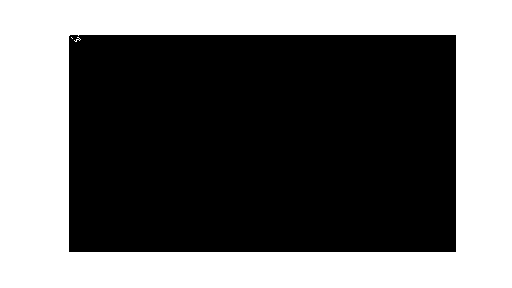
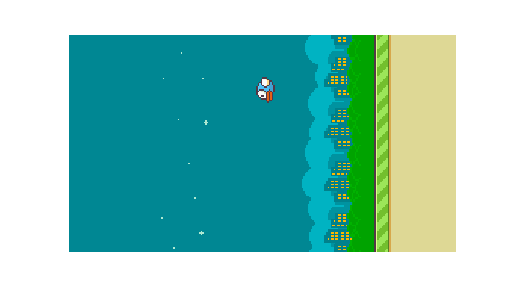
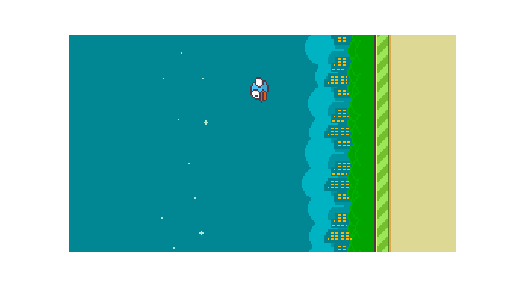
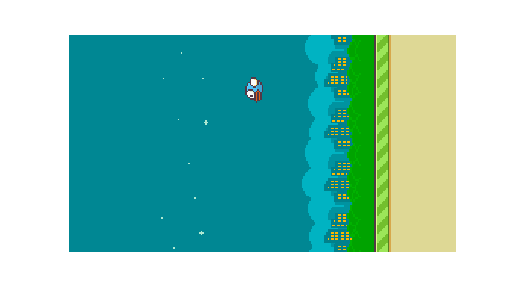
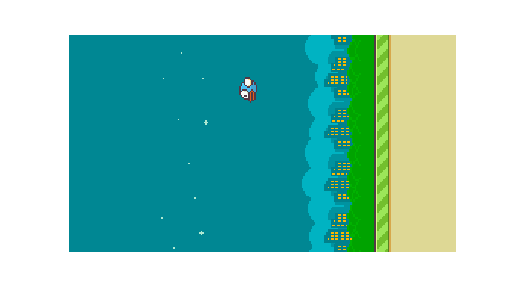
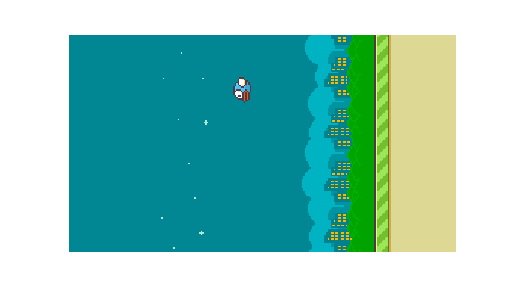
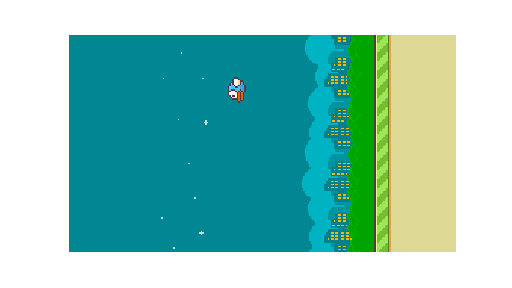
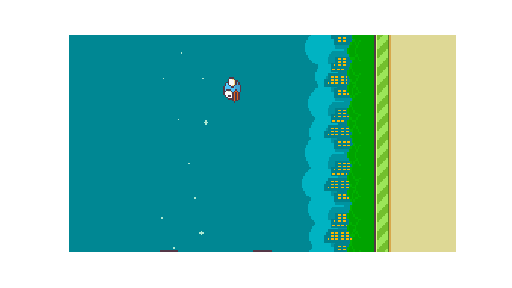
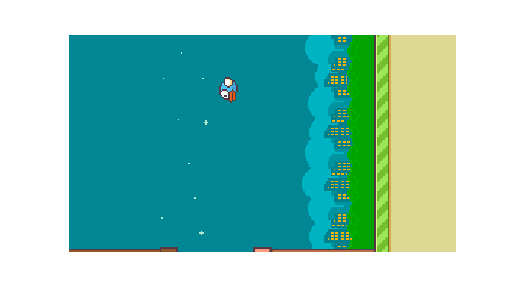
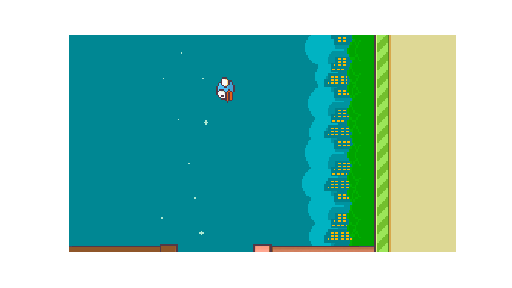
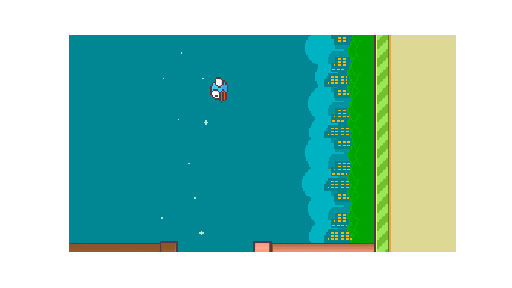
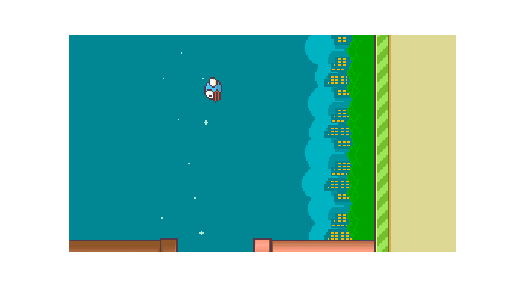
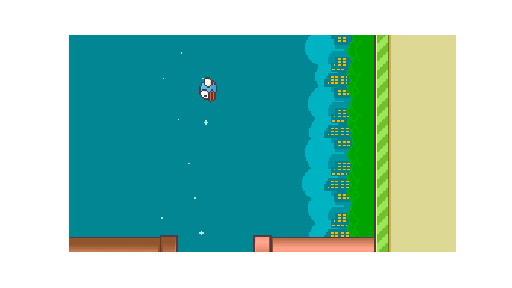
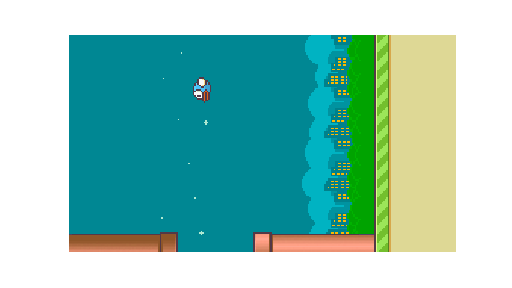
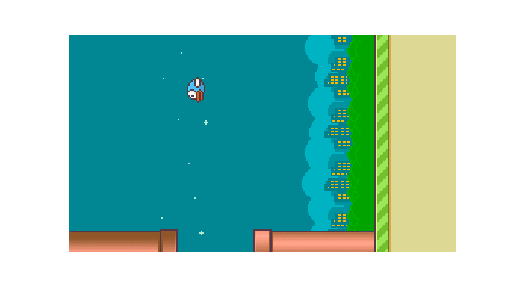
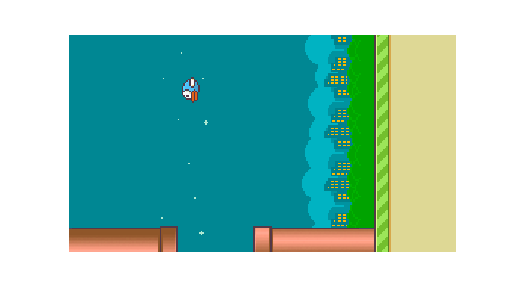
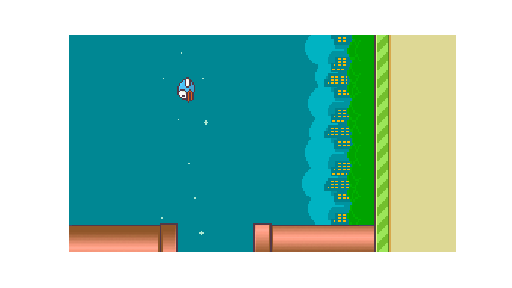
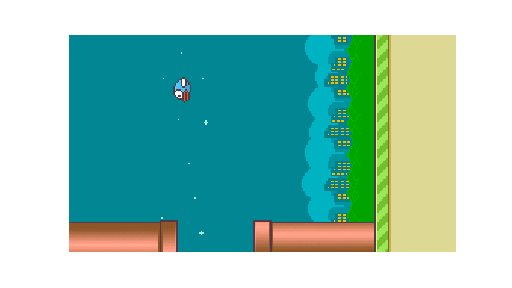
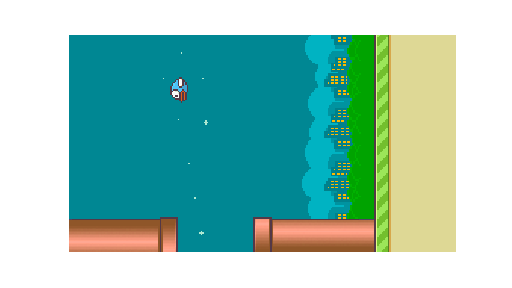
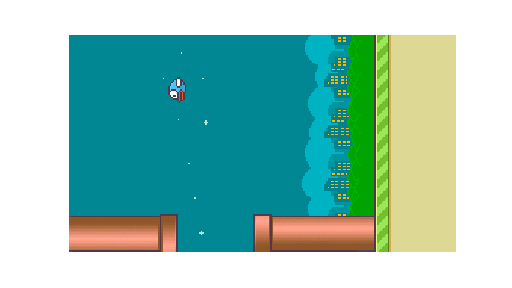
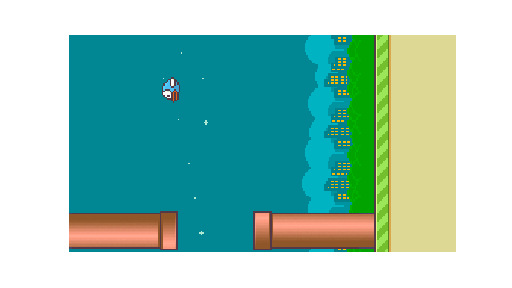
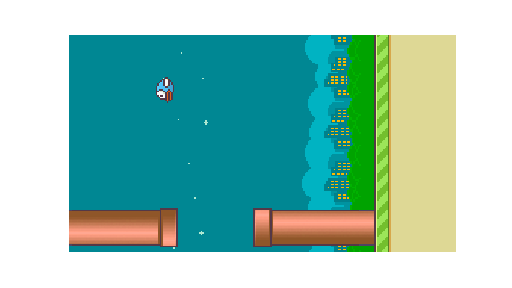
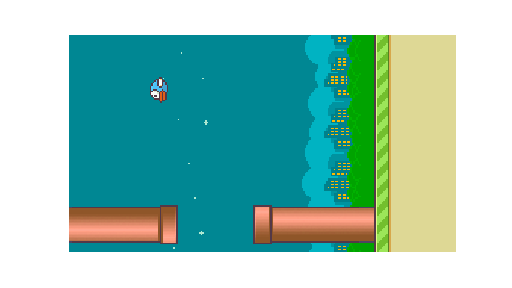
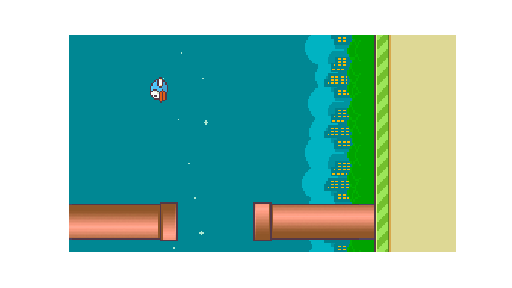
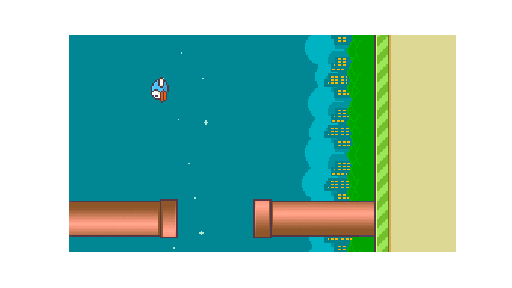
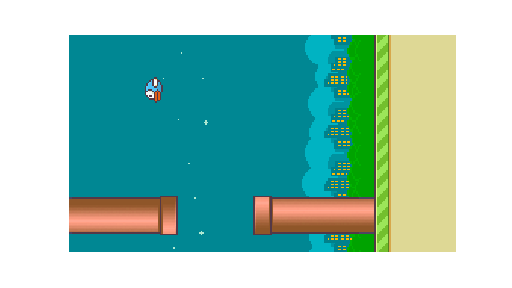
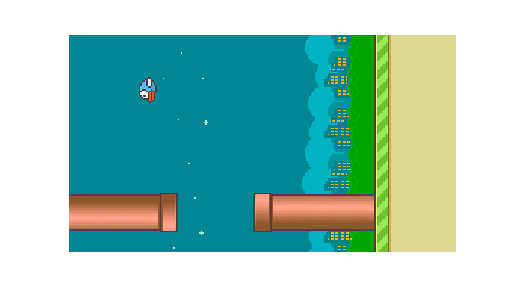
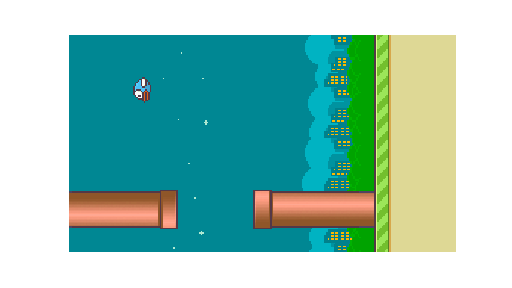
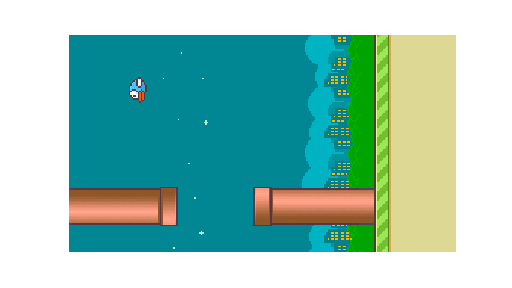
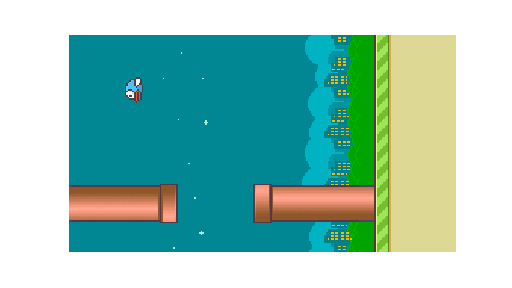
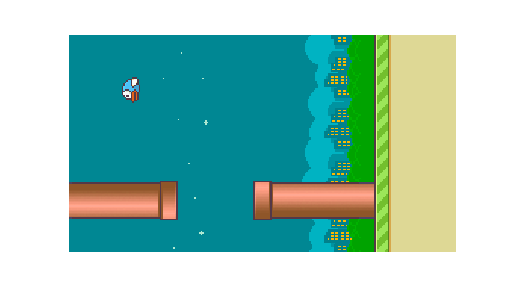
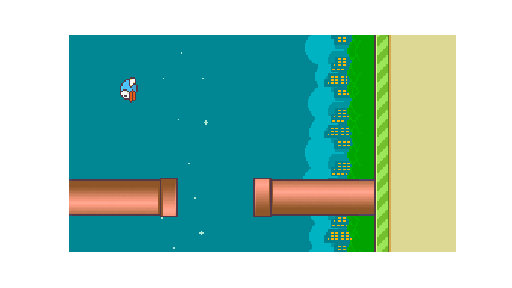
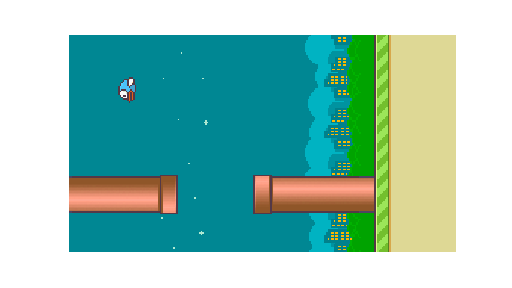
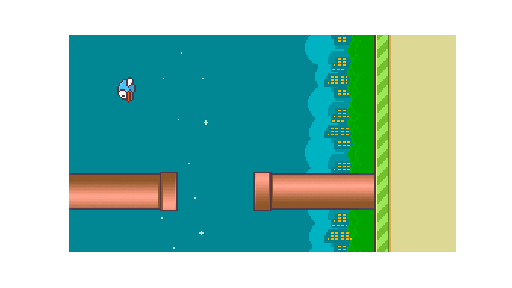
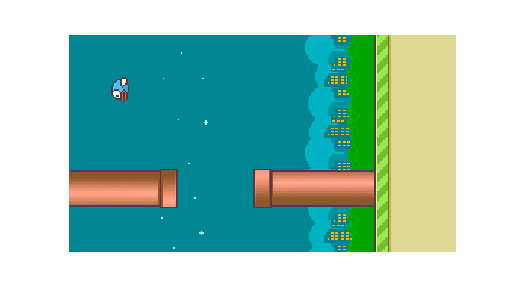
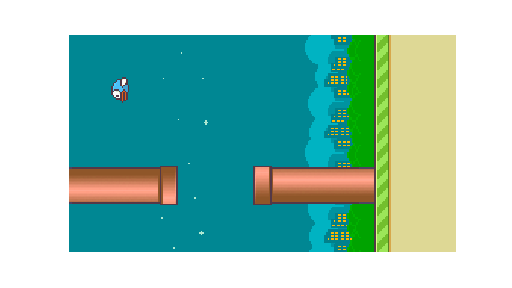
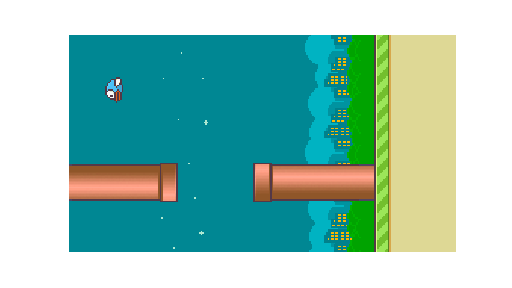
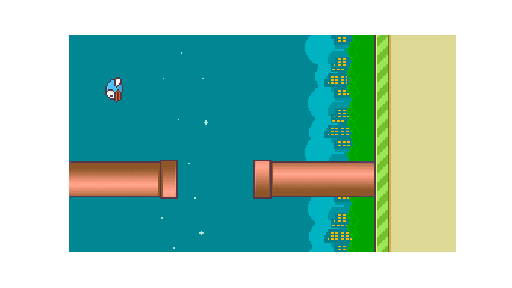
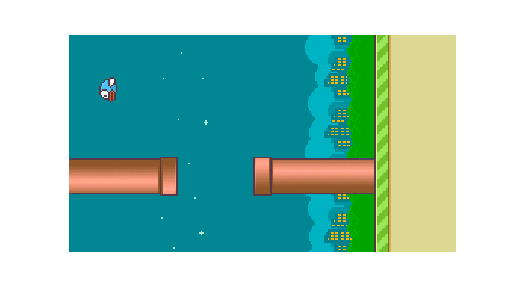
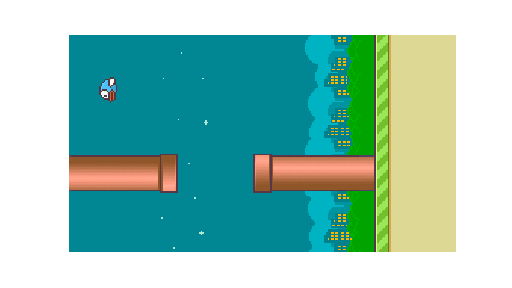
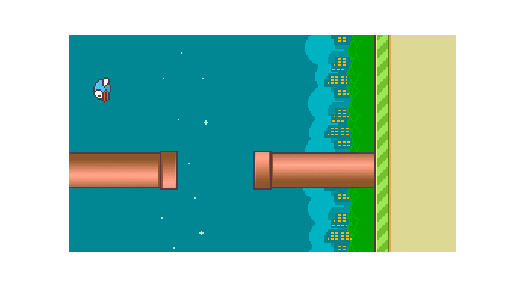
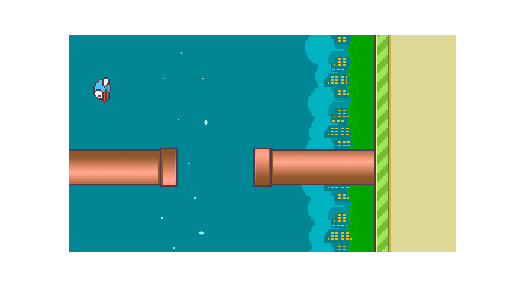
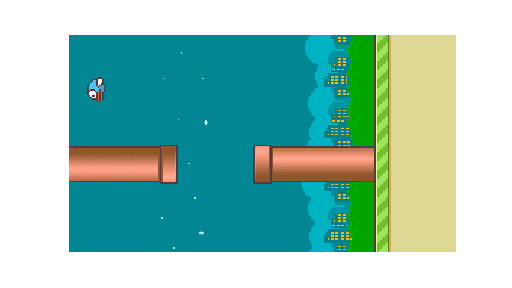
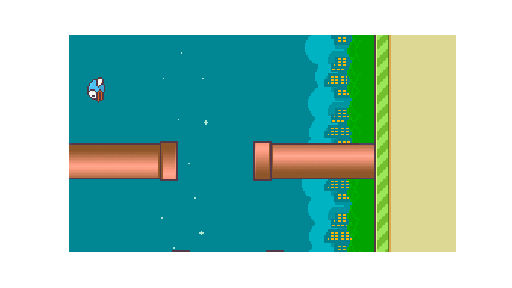
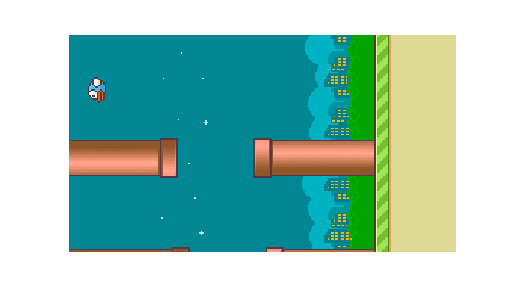
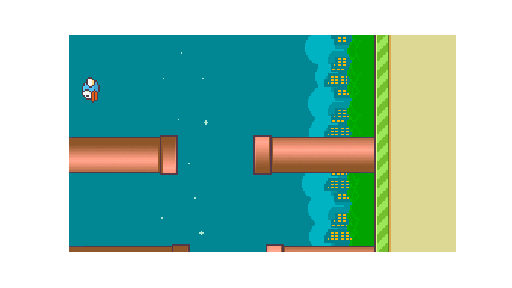
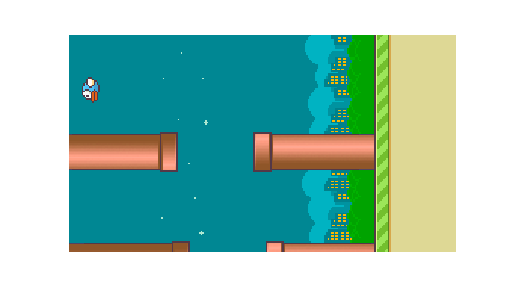
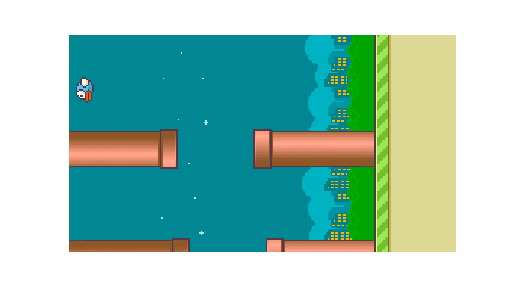
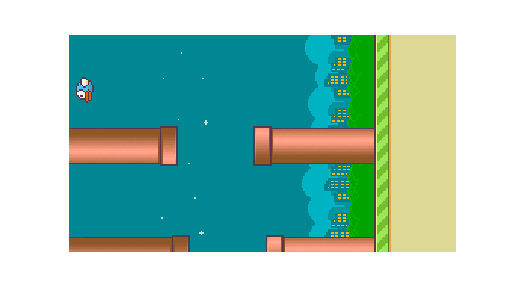
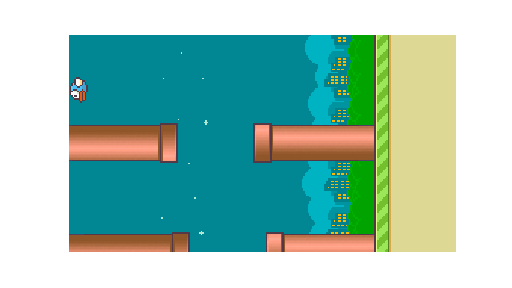
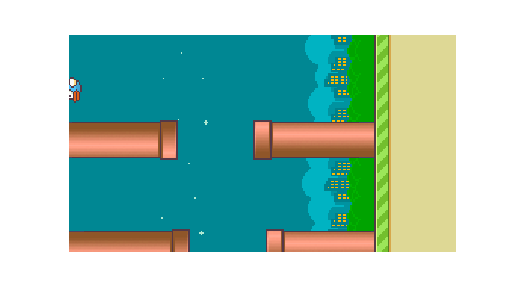
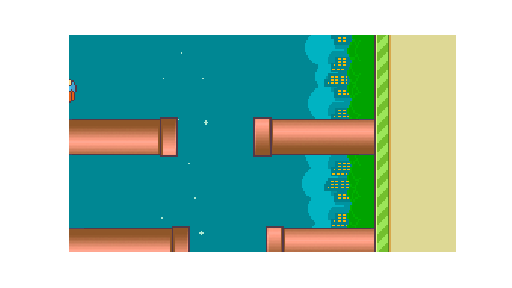

1 Episode: Finished after 44 steps：10試行の平均step数 = 9.6
2 Episode: Finished after 62 steps：10試行の平均step数 = 15.8
3 Episode: Finished after 63 steps：10試行の平均step数 = 22.1
4 Episode: Finished after 63 steps：10試行の平均step数 = 28.4
5 Episode: Finished after 55 steps：10試行の平均step数 = 33.9
6 Episode: Finished after 63 steps：10試行の平均step数 = 40.2
7 Episode: Finished after 63 steps：10試行の平均step数 = 46.5
8 Episode: Finished after 63 steps：10試行の平均step数 = 52.8
9 Episode: Finished after 63 steps：10試行の平均step数 = 59.1
10 Episode: Finished after 70 steps：10試行の平均step数 = 60.9
11 Episode: Finished after 63 steps：10試行の平均step数 = 62.8
12 Episode: Finished after 63 steps：10試行の平均step数 = 62.9
13 Episode: Finished after 65 steps：10試行の平均step数 = 63.1
14 Episode: Finished after 63 steps：10試行の平均step数 = 63.1
15 Episode: Finished after 63 steps：10試行の平均step数 = 63.9
16 Episode: Finished after 63 steps：10試行の平均step数 = 63.9
17 Episode: Finished after 63 steps：10試行の平均step数 = 63.9
18 Episode: Finished after 48 steps：10試行の平均step数 = 62.4
19

KeyboardInterrupt: 

In [39]:
# mainクラス
flappy_env = Environment()
flappy_env.run()

In [ ]:
torch.save(flappy_env.agent.brain.model.state_dict(), 'weight.pth')